Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges
        - calcul de stats
        - classif des communes 

        .....

In [19]:
class CFG:
    area = [
        'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté',
    'Brittany',
    'Centre-Val de Loire',
    'Grand Est',
    'Hauts-de-France',
    'Île-de-France',
    'Normandie',
    'Nouvelle-Aquitaine',
    'Occitanie',
    'Pays de la Loire',
    'Provence-Alpes-Côte d\'Azur'
]
    area_name = 'france'      #'_'.join(area)

    

    bornes = False

    viz = True

    roads = (
        '|motorway'
        '|motorway_link'
        '|trunk'
        '|trunk_link'
        '|primary'
        '|primary_link'
        '|secondary'
        '|secondary_link'
        '|tertiary'
         '|tertiary_link'
    )

        # '|primary'
        # '|motorway_link'
        
        # '|primary_link'

        # '|secondary'
        # '|secondary_link'
        
        
        #  '|tertiary'
        #  '|tertiary_link'

    data_path = './osm_datas/'

import joblib
joblib.dump(CFG.area, 'CFG.pkl')    

import os
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload


%aimport OSM_helper_functions
%aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
from OSM_helper_functions import *
from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 

Administratives = {
    'Auvergne-Rhône-Alpes': ['Ain', 'Allier', 'Ardèche', 'Cantal', 'Drôme', 'Isère', 'Loire', 'Haute-Loire', 'Puy-de-Dôme', 'Rhône', 'Savoie', 'Haute-Savoie'],
    'Bourgogne-Franche-Comté': ['Côte-d\'Or', 'Doubs', 'Jura', 'Nièvre', 'Haute-Saône', 'Saône-et-Loire', 'Yonne', 'Territoire de Belfort'],
    'Brittany': ['Côtes-d\'Armor', 'Finistère', 'Ille-et-Vilaine', 'Morbihan'],
    'Centre-Val de Loire': ['Cher', 'Eure-et-Loir', 'Indre', 'Indre-et-Loire', 'Loir-et-Cher', 'Loiret'],
    # 'Corse': ['Corse-du-Sud', 'Haute-Corse'],
    'Grand Est': ['Ardennes', 'Aube', 'Marne', 'Haute-Marne', 'Meurthe-et-Moselle', 'Meuse', 'Moselle', 'Bas-Rhin', 'Haut-Rhin', 'Vosges'],
    'Hauts-de-France': ['Aisne', 'Nord', 'Oise', 'Pas-de-Calais', 'Somme'],
    'Île-de-France': ['Paris', 'Seine-et-Marne', 'Yvelines', 'Essonne', 'Hauts-de-Seine', 'Seine-Saint-Denis', 'Val-de-Marne', 'Val-d\'Oise'],
    'Normandie': ['Calvados', 'Eure', 'Manche', 'Orne', 'Seine-Maritime'],
    'Nouvelle-Aquitaine': ['Charente', 'Charente-Maritime', 'Corrèze', 'Creuse', 'Dordogne', 'Gironde', 'Landes', 'Lot-et-Garonne', 'Pyrénées-Atlantiques', 'Deux-Sèvres', 'Vienne', 'Haute-Vienne'],
    'Occitanie': ['Ariège', 'Aude', 'Aveyron', 'Gard', 'Haute-Garonne', 'Gers', 'Hérault', 'Lot', 'Lozère', 'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Tarn', 'Tarn-et-Garonne'],
    'Pays de la Loire': ['Loire-Atlantique', 'Maine-et-Loire', 'Mayenne', 'Sarthe', 'Vendée'],
    'Provence-Alpes-Côte d\'Azur': ['Alpes-de-Haute-Provence', 'Hautes-Alpes', 'Alpes-Maritimes', 'Bouches-du-Rhône', 'Var', 'Vaucluse']
}

Regions = [
    'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté',
    'Brittany',
    'Centre-Val de Loire',
    # 'Corse',
    'Grand Est',
    'Hauts-de-France',
    'Île-de-France',
    'Normandie',
    'Nouvelle-Aquitaine',
    'Occitanie',
    'Pays de la Loire',
    'Provence-Alpes-Côte d\'Azur'
]

Name2num = {
    'Ain': '01',
    'Aisne': '02',
    'Allier': '03',
    'Alpes-de-Haute-Provence': '04',
    'Hautes-Alpes': '05',
    'Alpes-Maritimes': '06',
    'Ardèche': '07',
    'Ardennes': '08',
    'Ariège': '09',
    'Aube': '10',
    'Aude': '11',
    'Aveyron': '12',
    'Bouches-du-Rhône': '13',
    'Calvados': '14',
    'Cantal': '15',
    'Charente': '16',
    'Charente-Maritime': '17',
    'Cher': '18',
    'Corrèze': '19',
    # 'Corse-du-Sud': '2A',
    # 'Haute-Corse': '2B',
    'Côte-d\'Or': '21',
    'Côtes-d\'Armor': '22',
    'Creuse': '23',
    'Dordogne': '24',
    'Doubs': '25',
    'Drôme': '26',
    'Eure': '27',
    'Eure-et-Loir': '28',
    'Finistère': '29',
    'Gard': '30',
    'Haute-Garonne': '31',
    'Gers': '32',
    'Gironde': '33',
    'Hérault': '34',
    'Ille-et-Vilaine': '35',
    'Indre': '36',
    'Indre-et-Loire': '37',
    'Isère': '38',
    'Jura': '39',
    'Landes': '40',
    'Loir-et-Cher': '41',
    'Loire': '42',
    'Haute-Loire': '43',
    'Loire-Atlantique': '44',
    'Loiret': '45',
    'Lot': '46',
    'Lot-et-Garonne': '47',
    'Lozère': '48',
    'Maine-et-Loire': '49',
    'Manche': '50',
    'Marne': '51',
    'Haute-Marne': '52',
    'Mayenne': '53',
    'Meurthe-et-Moselle': '54',
    'Meuse': '55',
    'Morbihan': '56',
    'Moselle': '57',
    'Nièvre': '58',
    'Nord': '59',
    'Oise': '60',
    'Orne': '61',
    'Pas-de-Calais': '62',
    'Puy-de-Dôme': '63',
    'Pyrénées-Atlantiques': '64',
    'Hautes-Pyrénées': '65',
    'Pyrénées-Orientales': '66',
    'Bas-Rhin': '67',
    'Haut-Rhin': '68',
    'Rhône': '69',
    'Haute-Saône': '70',
    'Saône-et-Loire': '71',
    'Sarthe': '72',
    'Savoie': '73',
    'Haute-Savoie': '74',
    'Paris': '75',
    'Seine-Maritime': '76',
    'Seine-et-Marne': '77',
    'Yvelines': '78',
    'Deux-Sèvres': '79',
    'Somme': '80',
    'Tarn': '81',
    'Tarn-et-Garonne': '82',
    'Var': '83',
    'Vaucluse': '84',
    'Vendée': '85',
    'Vienne': '86',
    'Haute-Vienne': '87',
    'Vosges': '88',
    'Yonne': '89',
    'Territoire de Belfort': '90',
    'Essonne': '91',
    'Hauts-de-Seine': '92',
    'Seine-Saint-Denis': '93',
    'Val-de-Marne': '94',
    'Val-d\'Oise': '95'
}


AREA = []
for area in CFG.area:
    AREA.extend(Administratives[area] )
# AREA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))
# Nodes.index = Nodes.index.astype(int)

# Edges = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes0.pkl'))
# Edges = gpd.read_feather(
#     os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes_C21.feather')
#     )

Edges = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gedges_communes_C22.pkl'))

In [40]:
Nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34460 entries, 1149451 to 120979
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         34460 non-null  float64 
 1   x         34460 non-null  float64 
 2   codgeo    34460 non-null  object  
 3   area      34460 non-null  object  
 4   sleeping  15412 non-null  float64 
 5   visit     17921 non-null  float64 
 6   working   6950 non-null   float64 
 7   fooding   6616 non-null   float64 
 8   vehicule  4166 non-null   float64 
 9   geometry  34460 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 3.9+ MB


In [21]:
Edges = Edges.drop(['src_trgt'], axis=1)
Edges = Edges.reset_index()
Edges['key'] = Edges['key'].astype(str)
Edges = Edges.set_index(['u','v','key'])
PATHS = Edges.pop('path')
Edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 135685 entries, ('1149451', '1154468', '0') to ('120979', '120650', '0')
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     135685 non-null  geometry
 1   length       135685 non-null  float64 
 2   travel_time  135685 non-null  float64 
 3   path_line    135685 non-null  object  
dtypes: float64(2), geometry(1), object(1)
memory usage: 7.8+ MB


In [22]:
nodes2codgeo = dict(zip(Nodes.index, Nodes['codgeo']))

In [23]:
display(Nodes.head(2),Edges.head(2))

,y,x,codgeo,area,sleeping,visit,working,fooding,vehicule,geometry
osmid,,,,,,,,,,
1149451,50.582893,2.143174,62053,"POLYGON ((2.1236166085707024 50.6023317808971,...",3.0,1.0,NaN,NaN,NaN,POINT (2.14317 50.58289)
910704,49.717236,3.012390,80284,POLYGON ((3.0554823933057955 49.69360836687852...,NaN,1.0,NaN,NaN,NaN,POINT (3.01239 49.71724)


geometry  \
u       v       key                                                    
1149451 1154468 0    LINESTRING (2.14317 50.58289, 2.15286 50.57249)   
        1187157 0    LINESTRING (2.14317 50.58289, 2.13848 50.55981)   

                       length  travel_time  \
u       v       key                          
1149451 1154468 0    1372.651         86.5   
        1187157 0    3512.342        200.3   

                                                             path_line  
u       v       key                                                     
1149451 1154468 0    LINESTRING (2.1423984 50.5830442, 2.1424946 50...  
        1187157 0    LINESTRING (2.1423984 50.5830442, 2.1424946 50...

In [24]:
G_communes = ox.graph_from_gdfs(Nodes, Edges)

In [25]:
# ox.folium.plot_graph_folium(G_communes, graph_map=None, popup_attribute=None)

In [26]:
display(Nodes.head(1), Edges.head(1))

,y,x,codgeo,area,sleeping,visit,working,fooding,vehicule,geometry
osmid,,,,,,,,,,
1149451,50.582893,2.143174,62053,"POLYGON ((2.1236166085707024 50.6023317808971,...",3.0,1.0,NaN,NaN,NaN,POINT (2.14317 50.58289)


,,,geometry,length,travel_time,path_line
u,v,key,,,,
1149451,1154468,0,"LINESTRING (2.14317 50.58289, 2.15286 50.57249)",1372.651,86.5,"LINESTRING (2.1423984 50.5830442, 2.1424946 50..."


<AxesSubplot: ylabel='Frequency'>

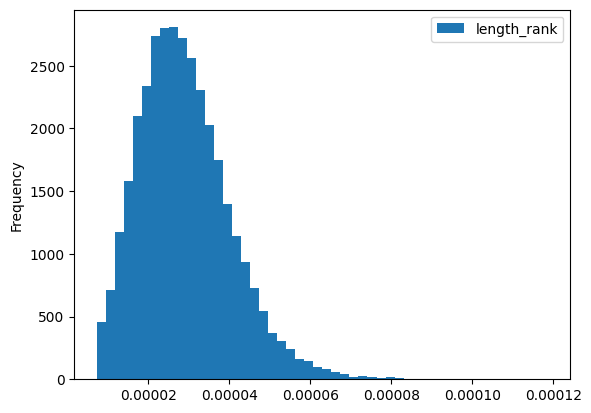

In [27]:
page_rank = nx.pagerank(
                    G_communes,
                    alpha=0.75,
                    personalization=None, 
                    max_iter=1000, 
                    tol=1e-06, 
                    nstart=None, 
                    weight='length', 
                    dangling=None
                )
pd.DataFrame.from_dict(page_rank, orient='index').rename(columns={0: 'length_rank'}).plot(kind='hist', bins=50)

In [28]:
Nodes.head(1)

,y,x,codgeo,area,sleeping,visit,working,fooding,vehicule,geometry
osmid,,,,,,,,,,
1149451,50.582893,2.143174,62053,"POLYGON ((2.1236166085707024 50.6023317808971,...",3.0,1.0,NaN,NaN,NaN,POINT (2.14317 50.58289)


revoir personalisation:
    ce parametre doit orienter la proba de certains edges

    il faut donc partir de .5 pour tous les nodes et 
    dans le cas de touristique 'orienter' vers 0 pour les lieus de residence 
    et 1.0 pour les lieux de migration
    verif:
        grand centres urbains vers 0
        lieux touristiques vers 1.0 (on doit retrouver les littoraux)


        perso = nx.get_node_attributes(graph, 'weigth')

min_sample 10  pas mal

In [29]:
Graph = ox.graph_from_gdfs(Nodes, Edges)

In [30]:
Nodes.head(1)

,y,x,codgeo,area,sleeping,visit,working,fooding,vehicule,geometry
osmid,,,,,,,,,,
1149451,50.582893,2.143174,62053,"POLYGON ((2.1236166085707024 50.6023317808971,...",3.0,1.0,NaN,NaN,NaN,POINT (2.14317 50.58289)


In [31]:
scores = pd.DataFrame(index = Nodes.index)

for tag in ['sleeping','visit','working','fooding','vehicule']:
    print(f'Computing for {tag=}')
    pers = nx.get_node_attributes(Graph, tag)
    min_val = min(pers.values())
    max_val = max(pers.values())
    pers = {key: (value - min_val) / ( max_val - min_val) for key, value in pers.items()}

    rank_length = nx.pagerank(
                    Graph,
                    alpha=0.85,
                    personalization=pers, 
                    max_iter=10000, 
                    tol=1e-06, 
                    nstart=None, 
                    weight='length', 
                    dangling=None
                )
    ranks = (
        pd.DataFrame
        .from_dict(
            rank_length, 
            orient='index'
        )
        .rename(
            columns={0: f'rank_{tag}'}
        )
    )
    scores = pd.concat(
        [scores,ranks],
        axis=1
    )
scores

Computing for tag='sleeping'
Computing for tag='visit'
Computing for tag='working'
Computing for tag='fooding'
Computing for tag='vehicule'


,rank_sleeping,rank_visit,rank_working,rank_fooding,rank_vehicule
1149451,1.093941e-05,4.775104e-06,1.898236e-06,2.649579e-06,1.898236e-06
910704,4.429773e-07,5.293472e-07,3.646440e-07,4.668693e-07,3.645742e-07
1452239,8.767585e-06,2.944143e-06,2.018694e-06,2.018694e-06,2.018694e-06
2173628,2.850409e-06,5.735688e-06,2.128292e-06,2.357796e-06,2.141179e-06
106436,2.110087e-05,1.816128e-05,3.692365e-06,1.971860e-05,4.422767e-06
...,...,...,...,...,...
2893288,1.193604e-05,7.381634e-05,8.882154e-05,4.630448e-06,2.936668e-05
186959,1.857198e-05,2.303516e-05,7.679313e-06,3.807552e-05,7.639506e-06
1405692,1.740185e-06,7.931183e-06,1.487464e-06,1.355942e-06,1.428525e-05
366442,2.638082e-05,2.728951e-05,8.896240e-07,2.188463e-05,2.321549e-05


<AxesSubplot: >

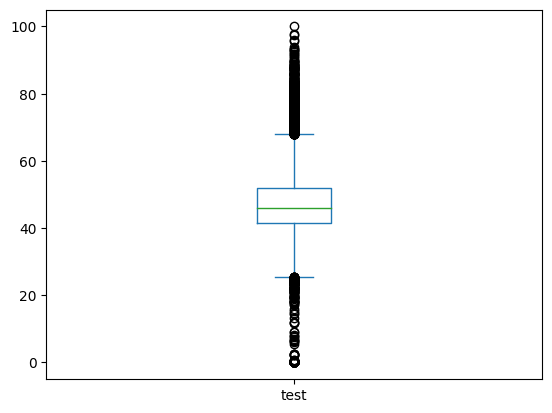

In [32]:
import numpy as np
scores['test'] = np.power(scores['rank_sleeping'], 1/7)
scores['test'] = scores['test'] * 100 / scores['test'].max()
scores['test'].plot(kind='box')

In [33]:
import folium
from folium.plugins import HeatMap
m = folium.Map(location= [48.8, 2.3],
                    width='100%', height='100%', left='00%', top='0%', 
                    position='relative', 
                    tiles= None, #'OpenStreetMap',     #OpenStreetMap', Stamen
                    attr=None,    #  None   Terrain, Toner, and Watercolor
                    min_zoom=4, max_zoom=20, zoom_start=7, 
                    min_lat= 41, max_lat=52, min_lon=- 4, max_lon=10, 
                    max_bounds=True, 
                    crs='EPSG3857', 
                    control_scale=True, prefer_canvas=False, 
                    no_touch=False, disable_3d=True, 
                    png_enabled=False, zoom_control=True)

folium.TileLayer('stamentoner',name="Light Map",control=False).add_to(m)

In [34]:

# Prepare datas
data = pd.concat(
            [Nodes,scores], axis=1)

data['geometry'] = data.pop('area')

data = data.reset_index()
data.head(1)

,index,y,x,codgeo,sleeping,visit,working,fooding,vehicule,geometry,rank_sleeping,rank_visit,rank_working,rank_fooding,rank_vehicule,test
0,1149451,50.582893,2.143174,62053,3.0,1.0,NaN,NaN,NaN,"POLYGON ((2.12362 50.60233, 2.12239 50.60111, ...",0.000011,0.000005,0.000002,0.000003,0.000002,46.17661


In [45]:
# verifications valeurs communes aprés visualisation de la carte

data.query(" codgeo == '92026' or codgeo == '92062' ")

,index,y,x,codgeo,sleeping,visit,working,fooding,vehicule,geometry,rank_sleeping,rank_visit,rank_working,rank_fooding,rank_vehicule,test
19397,91768,48.895333,2.256160,92026,4.0,2.0,NaN,5.0,1.0,"POLYGON ((2.26638 48.90634, 2.26704 48.90467, ...",0.000037,32.222621,16.442636,0.000048,0.000029,55.010325
20699,91776,48.884152,2.236886,92062,5.0,9.0,3.0,NaN,NaN,"POLYGON ((2.24571 48.87646, 2.25100 48.88116, ...",0.000031,31.406866,17.433515,0.000017,0.000019,53.679167


In [51]:
tourism = gpd.read_feather(os.path.join(CFG.data_path,'datatourisme-place-20230529-tagged' + '.feather'))

In [52]:
tourism.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 338032 entries, 0 to 338031
Data columns (total 19 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   Nom_du_POI                                338032 non-null  object  
 1   Categories_de_POI                         338032 non-null  object  
 2   Latitude                                  338032 non-null  object  
 3   Longitude                                 338032 non-null  object  
 4   Adresse_postale                           338032 non-null  object  
 5   Code_postal_et_commune                    338032 non-null  object  
 6   Covid19_mesures_specifiques               338032 non-null  object  
 7   Covid19_est_en_activite                   338032 non-null  object  
 8   Covid19_periodes_d_ouvertures_confirmees  338032 non-null  object  
 9   Createur_de_la_donnee                     338032 non-null  object  
 10  

In [53]:
tourism.query(" Code_postal_et_commune.str.contains('92400') or  Code_postal_et_commune.str.contains('92800') ")

,Nom_du_POI,Categories_de_POI,Latitude,Longitude,Adresse_postale,Code_postal_et_commune,Covid19_mesures_specifiques,Covid19_est_en_activite,Covid19_periodes_d_ouvertures_confirmees,Createur_de_la_donnee,SIT_diffuseur,Date_de_mise_a_jour,Contacts_du_POI,Classements_du_POI,Description,URI_ID_du_POI,geometry,tag,Class
7373,Adagio City Aparthotel Kleber La Défense,https://www.datatourisme.fr/ontology/core#Plac...,48.8942177,2.2486810000000332,73 avenue Gambetta,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2022-07-11,#+33 1 56 37 20 00#H6788@adagio-city.com#http:...,4 étoiles#Classement officiel des hébergements...,Cette résidence de tourisme est installée sur ...,https://data.datatourisme.fr/19/7dc099ed-4782-...,POINT (2.24868 48.89422),HolidayResort,"leisure center, therapy center, outdoor activi..."
8148,Adagio La Défense Le Parc,https://www.datatourisme.fr/ontology/core#Plac...,48.8971723,2.2363632999999936,1 rue des Lilas d'Espagne,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2022-07-11,#+33 1 55 70 79 79#h6787@adagio-city.com#http:...,4 étoiles#Classement officiel des hébergements...,Cette résidence de tourisme est installée dans...,https://data.datatourisme.fr/19/d15c4bb8-a603-...,POINT (2.23636 48.89717),HolidayResort,"leisure center, therapy center, outdoor activi..."
8401,Adagio access La Défense Léonard de Vinci,https://www.datatourisme.fr/ontology/core#Plac...,48.8968415,2.2346697000000404,88 rue des Étudiants,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2021-02-16,#+33 1 41 88 20 00#H8363@adagio-city.com#http:...,4 étoiles#Classement officiel des hébergements...,Cette résidence de tourisme se situe face au p...,https://data.datatourisme.fr/19/98223472-d0e5-...,POINT (2.23467 48.89684),HolidayResort,"leisure center, therapy center, outdoor activi..."
9577,Adagio La Défense Puteaux,https://www.datatourisme.fr/ontology/core#Plac...,48.8847469,2.24424190000002,70 rue Roque de Fillol,92800#Puteaux,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2021-02-16,#+33 1 55 62 12 00#h8987@adagio-city.com#https...,3 étoiles#Classement officiel des hébergements...,Cette résidence de tourisme est située dans le...,https://data.datatourisme.fr/19/02498904-2d48-...,POINT (2.24424 48.88475),HolidayResort,"leisure center, therapy center, outdoor activi..."
11075,Fraser Suites Harmonie Paris La Défense,https://www.datatourisme.fr/ontology/core#Plac...,48.8892055,2.25083989999996,6 boulevard de Neuilly,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2022-11-23,#+33 1 55 23 26 00#sales.paris@frasershospital...,5 étoiles#Classement officiel des hébergements...,Cette résidence de tourisme accueille sa clien...,https://data.datatourisme.fr/19/eaf010cb-52b8-...,POINT (2.25084 48.88921),HolidayResort,"leisure center, therapy center, outdoor activi..."
11367,Adagio La Défense Courbevoie,https://www.datatourisme.fr/ontology/core#Plac...,48.8933593,2.253148900000042,2 - 4 Place des Pléiades,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2021-02-16,#+33 1 46 40 85 20#h9297@adagio-city.com#https...,4 étoiles#Classement officiel des hébergements...,Cette résidence se situe tout près du bowling ...,https://data.datatourisme.fr/19/ab725ad5-a62f-...,POINT (2.25315 48.89336),HolidayResort,"leisure center, therapy center, outdoor activi..."
32723,Ibis Paris La Défense Centre,https://www.datatourisme.fr/ontology/core#Plac...,48.88845269999999,2.250994300000002,4 boulevard de Neuilly,92400#Courbevoie,,,,Office de Tourisme de Paris,Office de Tourisme de Paris,2022-07-11,#+33 1 41 97 40 40#H0771@accor.com#https://ibi...,3 étoiles#Classement officiel des hébergements...,Implanté au cœur du quartier des affaires de L...,https://data.datatourisme.fr/19/6ddb9f39-550b-...,POINT (2.25099 48.88845),HotelTrade,"hotel, bed, housse rental, vacation rental, ca..."
53886,Meliá Paris La Défense,https://www.datatouris

### Ne pas utilser le tag working pour migration vers les bureaux prendre à la place le nobre d'habitants par communes / par le nombre de voitures pour obtenir un indice de mobilité . Considérer working comme deplacements vers salons/expos et les autres comme déplacements de loisirs (que l'on pourra ainsi detailler et pondérer)

------------------------------

In [35]:
import numpy as np

tag_color = {
   'sleeping': 'Blues',
   'visit': 'Greens',
   'working': 'Oranges',
   'fooding': 'Purples',
   'vehicule': 'Greys'
}

n = 0
for tag in ['visit','working','sleeping','fooding','vehicule']:
    print(f'Layer: {tag=}')

    # Unskeew and scale socres
    data[f'rank_{tag}'] = np.power(data[f'rank_{tag}'], 1/3)
    data[f'rank_{tag}'] = data[f'rank_{tag}'] * 100 / data[f'rank_{tag}'].max()
#    (
    folium.Choropleth(
            geo_data = data, #.to_json(),
            name=f"{tag}",
            data=data,
            columns=["index",f'rank_{tag}'],
            key_on="feature.properties.index",
            fill_color= tag_color[tag], #"YlGnBu",
            fill_opacity=0.6,
            line_opacity=.08,
            legend_name= tag,
        ).add_to(m)
    # )
    if n ==1 : break
    n += 1

folium.LayerControl().add_to(m)

m.save(os.path.join(CFG.data_path, f'[{CFG.area_name}]page_rank_map.html'))
# display (m)
del m

Layer: tag='visit'
Layer: tag='working'


---------------------------------------------------

In [36]:
*********** fin

SyntaxError: invalid syntax (656072225.py, line 1)

In [ ]:
pers = nx.get_node_attributes(Graph, 'visit')
min_val = min(pers.values())
max_val = max(pers.values())
pers = {key: (value - min_val) / ( max_val - min_val) for key, value in pers.items()}
pers

In [ ]:



rank_length = nx.pagerank(
                    Graph,
                    alpha=0.85,
                    personalization=pers, 
                    max_iter=10000, 
                    tol=1e-06, 
                    nstart=None, 
                    weight='length', 
                    dangling=None
                )
ranks = (
    pd.DataFrame
    .from_dict(
        rank_length, 
        orient='index'
    )
    .rename(
        columns={0: 'length_rank'}
    )
)
# ranks['length_rank'] = scaler.fit_transform(ranks['length_rank'].values.reshape(-1, 1))
ranks['length_rank'] = ranks['length_rank'] / ranks['length_rank'].max()

ranks.plot(kind='hist', bins=150,)# xlim=(0,1.0))


reste à afficher sur une carte chloropleth communes-rank

In [ ]:
ranks.info()

In [ ]:
Nodes.info()

In [ ]:
import folium
from folium.plugins import HeatMap
m = folium.Map(location= [48.8, 2.3],
                    width='100%', height='100%', left='00%', top='0%', 
                    position='relative', 
                    tiles= 'OpenStreetMap',     #OpenStreetMap', Stamen
                    attr=None,    #  None   Terrain, Toner, and Watercolor
                    min_zoom=6, max_zoom=20, zoom_start=12, 
                    min_lat= 41, max_lat=52, min_lon=- 4, max_lon=10, 
                    max_bounds=False, 
                    crs='EPSG3857', 
                    control_scale=True, prefer_canvas=False, 
                    no_touch=False, disable_3d=True, 
                    png_enabled=False, zoom_control=True)

# Prepare datas
data = pd.concat(
            [Nodes,ranks], axis=1)
# data = data.drop([y	x], axis=1)
data['geometry'] = data.pop('area')
data = data.reset_index()
# data.head(1)

In [ ]:

folium.Choropleth(
    geo_data = data, #.to_json(),
    name="page_rank",
    data=data,
    columns=["index","length_rank"],
    key_on="feature.properties.index",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="page_rank  tags (%)",
).add_to(m)

# folium.LayerControl().add_to(m)

display (m)
del m

------------------------------------------

# Unsupervised labelling

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

df = Nodes[['sleeping','visit','working','fooding','vehicule'	]].fillna(0)

scaler = StandardScaler(with_mean=False, with_std=True)
df_scaled = scaler.fit_transform(df) 


dbscan = DBSCAN(
    eps=0.1,
    min_samples=10, 
    metric='euclidean', 
    metric_params=None, 
    algorithm='auto', 
    leaf_size=10, 
    p=2.5, 
    n_jobs=-1).fit(df_scaled)

print(f'{len(set(dbscan.labels_))=}')
pd.DataFrame(
    np.transpose(
        np.unique(
            dbscan.labels_, 
            return_counts=True
        )
    ), 
    columns=['label', 'count']
).set_index('label').T



In [ ]:
Nodes['labels'] = dbscan.labels_
Nodes['labels'] = Nodes['labels'].replace(-1,  np.nan).replace(0, np.nan)
Nodes['labels'].value_counts()

In [ ]:
# display(Nodes.shape[0])
# pers = Nodes['labels'].dropna()
# display(pers.shape[0])
# personalisation = dict(zip(pers.index, pers))

# + page_rank function call

-----------------------------------

In [ ]:
undirected_graph = ox.utils_graph.get_undirected(
                            Graph
                    )

In [ ]:
from networkx.algorithms import node_classification

node_classification.harmonic_function(
    undirected_graph,
     max_iter=30, 
     label_name='label'    
)